In [2]:
import os

import numpy as np
import openml
import pandas as pd
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from umap import UMAP
from tqdm import tqdm


In [3]:
import sys
from pathlib import Path

# Get the absolute path of the project root directory (go up one level from 'notebooks')
project_root = Path.cwd().parent
sys.path.append(str(project_root))

# Dataset setup 

## Download datasets

In [4]:
datasets = openml.datasets.list_datasets()
print(openml.datasets.list_datasets()[531])

ids = list(datasets.keys())
print("Number of datasets: ", len(ids))

# Removing non-dataset entries 
ids.remove(4537)
ids.remove(4546)
ids.remove(4562)

# Fetching dataset
datasets = openml.datasets.get_datasets(ids, download_data=False, download_qualities=False)
datasets[0]

{'did': 531, 'name': 'boston', 'version': 1, 'uploader': '2', 'status': 'active', 'format': 'ARFF', 'MaxNominalAttDistinctValues': 9.0, 'NumberOfClasses': 0.0, 'NumberOfFeatures': 14.0, 'NumberOfInstances': 506.0, 'NumberOfInstancesWithMissingValues': 0.0, 'NumberOfMissingValues': 0.0, 'NumberOfNumericFeatures': 12.0, 'NumberOfSymbolicFeatures': 2.0}
Number of datasets:  5466


OpenML Dataset
Name.........: anneal
Version......: 1
Format.......: ARFF
Upload Date..: 2014-04-06 23:19:24
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/1666876/anneal.arff
OpenML URL...: https://www.openml.org/d/2
# of features: 39

In [5]:
datasets[0].upload_date

'2014-04-06T23:19:24'

In [6]:
df = pd.DataFrame([dataset.__dict__ for dataset in datasets])
# Add the OpenML URL to the dataframe
df['openml_url'] = [dataset.openml_url for dataset in datasets]
df['upload_date'] = [dataset.upload_date for dataset in datasets]
# All datasets which have None description, make it an empty string ""
df['description'] = df['description'].fillna('')
df  

,ignore_attribute,dataset_id,name,version,description,cache_format,format,creator,contributor,collection_date,...,parquet_file,_dataset,_parquet_url,_features,_qualities,_no_qualities_found,data_pickle_file,data_feather_file,feather_attribute_file,openml_url
0,None,2,anneal,1,**Author**: Unknown. Donated by David Sterling...,pickle,ARFF,"[David Sterling, Wray Buntine]",David Sterling and Wray Buntine,1990,...,None,None,http://openml1.win.tue.nl/dataset2/dataset_2.pq,"{0: [0 - family (nominal)], 1: [1 - product-ty...",None,False,None,None,None,https://www.openml.org/d/2
1,None,3,kr-vs-kp,1,Author: Alen Shapiro\nSource: [UCI](https://ar...,pickle,ARFF,Alen Shapiro,Rob Holte,1989-08-01,...,None,None,http://openml1.win.tue.nl/dataset3/dataset_3.pq,"{0: [0 - bkblk (nominal)], 1: [1 - bknwy (nomi...",None,False,None,None,None,https://www.openml.org/d/3
2,None,4,labor,1,**Author**: Unknown\n**Source**: Collective Ba...,pickle,ARFF,Collective Bargaining Review of Labour Canada,Stan Matwin,1988-11-01,...,None,None,http://openml1.win.tue.nl/dataset4/dataset_4.pq,"{0: [0 - duration (numeric)], 1: [1 - wage-inc...",None,False,None,None,None,https://www.openml.org/d/4
3,None,5,arrhythmia,1,"**Author**: H. Altay Guvenir, Burak Acar, Hald...",pickle,ARFF,"[H. Altay Guvenir, Burak Acar, Haldun Muderris...",None,1998-01-01,...,None,None,http://openml1.win.tue.nl/dataset5/dataset_5.pq,"{0: [0 - age (numeric)], 1: [1 - sex (nominal)...",None,False,None,None,None,https://www.openml.org/d/5
4,None,6,letter,1,**Author**: David J. Slate \n**Source**: [UCI...,pickle,ARFF,David J. Slate,None,1991-01-01,...,None,None,http://openml1.win.tue.nl/dataset6/dataset_6.pq,"{0: [0 - x-box (numeric)], 1: [1 - y-box (nume...",None,False,None,None,None,https://www.openml.org/d/6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,None,45950,Heart_Failure_Prediction,1,"Description:\nThis dataset, named ""heart_failu...",pickle,arff,None,"Aadarsh velu (Owner), ANTONY ALEXIA (Admin)",05-05-2024,...,None,None,https://openml1.win.tue.nl/datasets/0004/45950...,"{0: [0 - age (numeric)], 1: [1 - anaemia (nume...",None,False,None,None,None,https://www.openml.org/d/45950
5459,None,45951,Lichess_Games_Dataset,1,Description:\nThe dataset games.csv is a compr...,pickle,arff,None,Mitchell J (Owner),07-05-2023,...,None,None,https://openml1.win.tue.nl/datasets/0004/45951...,"{0: [0 - id (string)], 1: [1 - rated (nominal)...",None,False,None,None,None,https://www.openml.org/d/45951
5460,None,45952,Linkedin_Job_Postings,1,"Description:\nThe ""postings.csv"" dataset compr...",pickle,arff,None,"Arsh Kon (Owner), Zoey Yu Zou (Admin)",23-08-2023,...,None,None,https://openml1.win.tue.nl/datasets/0004/45952...,"{0: [0 - job_id (string)], 1: [1 - company_nam...",None,False,None,None,None,https://www.openml.org/d/45952
5461,None,45954,Crime_Data_from_2020_to_present_in_Los_Angeles,1,"Description:\nThis dataset, named Crime_Data_f...",pickle,arff,-,Varun Deepak Gudhe,01-01-2024,...,None,None,https://openml1.win.tue.nl/datasets/0004/45954...,"{0: [0 - DR_NO (numeric)], 1: [1 - Date Rptd (...",None,False,None,None,None,https://www.openml.org/d/45954


## Dataset augmentation

In [7]:
import importlib

from src.augmenters import tag_augmenter, feature_augmenter, dataset_augmenter, similarity_augmenter, name_augmenter, \
    scrapy_augmenter, llm_prompt_augmenter

importlib.reload(tag_augmenter)
from src.augmenters import TagAugmenter

importlib.reload(feature_augmenter)
from src.augmenters import FeatureAugmenter

importlib.reload(dataset_augmenter)
from src.augmenters import DatasetAugmenter

importlib.reload(similarity_augmenter)
from src.augmenters import SimilarityAugmenter

importlib.reload(name_augmenter)
from src.augmenters import NameAugmenter

importlib.reload(scrapy_augmenter)
from src.augmenters import ScrapyAugmenter

importlib.reload(llm_prompt_augmenter)
from src.augmenters import LLMPromptAugmenter 

description_column = 'description'
tag_column = 'tag'
features_column = '_features'
name_column = 'name'
augmented_column = 'augmented_description'
similar_datasets_column = 'similar_datasets'
scraped_column = 'scraped_data'
prompt_description_column = 'prompt_description'

augmenters = [
    TagAugmenter(description_column, tag_column, augmented_column),
    NameAugmenter(description_column, name_column, augmented_column),
    FeatureAugmenter(description_column, features_column, augmented_column, max_features=100, reduce_features=True),
    ScrapyAugmenter(description_column, scraped_column, augmented_column),
    SimilarityAugmenter(description_column, augmented_column, similar_datasets_column),
    LLMPromptAugmenter(prompt_description_column)
]

dataset_augmenter = DatasetAugmenter(augmenters=augmenters)
augmented_df = dataset_augmenter.augment(df.copy())
augmented_df

FileNotFoundError: dataset_45944.txt not found
Removing row 5283 from the DataFrame.
FileNotFoundError: dataset_45945.txt not found
Removing row 5284 from the DataFrame.
FileNotFoundError: dataset_45948.txt not found
Removing row 5285 from the DataFrame.
FileNotFoundError: dataset_45949.txt not found
Removing row 5286 from the DataFrame.
FileNotFoundError: dataset_45950.txt not found
Removing row 5287 from the DataFrame.
FileNotFoundError: dataset_45951.txt not found
Removing row 5288 from the DataFrame.
FileNotFoundError: dataset_45952.txt not found
Removing row 5289 from the DataFrame.
FileNotFoundError: dataset_45954.txt not found
Removing row 5290 from the DataFrame.
FileNotFoundError: dataset_45955.txt not found
Removing row 5291 from the DataFrame.


,ignore_attribute,dataset_id,name,version,description,cache_format,format,creator,contributor,collection_date,...,_qualities,_no_qualities_found,data_pickle_file,data_feather_file,feather_attribute_file,openml_url,augmented_description,scraped_data,similar_datasets,prompt_description
0,None,2,anneal,1,**Author**: Unknown. Donated by David Sterling...,pickle,ARFF,"[David Sterling, Wray Buntine]",David Sterling and Wray Buntine,1990,...,None,False,None,None,None,https://www.openml.org/d/2,"Name: anneal\n\nTags: Manufacturing, study_1, ...",Dataset Information Additional Information Att...,[],"Anneal \nTags: Manufacturing, Study One, Study..."
1,None,3,kr-vs-kp,1,Author: Alen Shapiro\nSource: [UCI](https://ar...,pickle,ARFF,Alen Shapiro,Rob Holte,1989-08-01,...,None,False,None,None,None,https://www.openml.org/d/3,"Name: kr-vs-kp\n\nTags: Machine Learning, Math...",Dataset Information Additional Information The...,[],**Chess End-Game - King + Rook versus King + P...
2,None,4,labor,1,**Author**: Unknown\n**Source**: Collective Ba...,pickle,ARFF,Collective Bargaining Review of Labour Canada,Stan Matwin,1988-11-01,...,None,False,None,None,None,https://www.openml.org/d/4,"Name: labor\n\nTags: Economics, Education, myt...",Dataset Information Additional Information Dat...,[],**Labor Negotiations**\n\nThis dataset pertain...
3,None,5,arrhythmia,1,"**Author**: H. Altay Guvenir, Burak Acar, Hald...",pickle,ARFF,"[H. Altay Guvenir, Burak Acar, Haldun Muderris...",None,1998-01-01,...,None,False,None,None,None,https://www.openml.org/d/5,"Name: arrhythmia\n\nTags: Machine Learning, Me...",Dataset Information Additional Information Thi...,[],"Arrhythmia \n\nTags: Machine Learning, Medicin..."
4,None,6,letter,1,**Author**: David J. Slate \n**Source**: [UCI...,pickle,ARFF,David J. Slate,None,1991-01-01,...,None,False,None,None,None,https://www.openml.org/d/6,"Name: letter\n\nTags: AzurePilot, AzurePilot1,...",Dataset Information Additional Information The...,[],Title: Letter Image Recognition Data\n\nThe ob...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458,None,45950,Heart_Failure_Prediction,1,"Description:\nThis dataset, named ""heart_failu...",pickle,arff,None,"Aadarsh velu (Owner), ANTONY ALEXIA (Admin)",05-05-2024,...,None,False,None,None,None,https://www.openml.org/d/45950,Name: Heart_Failure_Prediction\n\nTags: \n\nDe...,,[],
5459,None,45951,Lichess_Games_Dataset,1,Description:\nThe dataset games.csv is a compr...,pickle,arff,None,Mitchell J (Owner),07-05-2023,...,None,False,None,None,None,https://www.openml.org/d/45951,Name: Lichess_Games_Dataset\n\nTags: \n\nDescr...,,[],
5460,None,45952,Linkedin_Job_Postings,1,"Description:\nThe ""postings.csv"" dataset compr...",pickle,arff,None,"Arsh Kon (Owner), Zoey Yu Zou (Admin)",23-08-2023,...,None,False,None,None,None,https://www.openml.org/d/45952,Name: Linkedin_Job_Postings\n\nTags: \n\nDescr...,,[],
5461,None,45954,Crime_Data_from_2020_to_present_in_Los_Angeles,1,"Description:\nThis dataset, named Crime_Data_f...",pickle,arff,-,Varun Deepak Gudhe,01-01-2024,...,None,False,None,None,None,https://www.openml.org/d/45954,Name: Crime_Data_from_2020_to_present_in_Los_A...,,[],


In [8]:
print(augmented_df.iloc[4500].augmented_description)
print('------------------------------------------------------------')
print(augmented_df.iloc[4500].prompt_description)

Name: airlines_seed_0_nrows_2000_nclasses_10_ncols_100_stratify_True

Tags: 

Subsampling of the dataset airlines (1169) with

seed=0
args.nrows=2000
args.ncols=100
args.nclasses=10
args.no_stratify=True
Generated with the following source code:


```python
    def subsample(
        self,
        seed: int,
        nrows_max: int = 2_000,
        ncols_max: int = 100,
        nclasses_max: int = 10,
        stratified: bool = True,
    ) -> Dataset:
        rng = np.random.default_rng(seed)

        x = self.x
        y = self.y

        # Uniformly sample
        classes = y.unique()
        if len(classes) > nclasses_max:
            vcs = y.value_counts()
            selected_classes = rng.choice(
                classes,
                size=nclasses_max,
                replace=False,
                p=vcs / sum(vcs),
            )

            # Select the indices where one of these classes is present
            idxs = y.index[y.isin(classes)]
            x = x.iloc[idxs]
     

In [9]:
# Changing a few specific datasets that are too long
# 213
augmented_df[augmented_column].iat[213] = augmented_df[augmented_column].iat[213][:24500]

In [10]:
len(augmented_df[augmented_column].iat[213])

24500

### Save augmented descriptions

In [11]:
if not os.path.exists("data"):
    os.makedirs("data")

augmented_df[augmented_column].to_csv("data/augmented_datasets.csv", index=False)
augmented_df[prompt_description_column].to_csv("data/prompt_descriptions.csv", index=False)

# data = augmented_df[augmented_column].tolist()
data = augmented_df[prompt_description_column].tolist()

### Define lemmatizer

Define lemmatizer which removes punctuation, stopwords and lemmatizes the text.

In [12]:
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer

nlp = spacy.load("en_core_web_lg")

def preprocess_text(text):
    # Replace underscores and dashes with spaces
    # text = text.replace('_', ' ').replace('-', ' ')
    # Insert a space before all caps (but not at the start of the string)
    # text = re.sub(r'(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])', ' ', text)
    # Remove many whitespaces
    text = re.sub(r'\s+', ' ', text)

    return text


# Define a custom tokenizer using spaCy for lemmatization and include preprocessing
def spacy_lemmatizer(doc):
    doc = preprocess_text(doc)
    return [token.lemma_.lower() for token in nlp(doc) if not token.is_punct and not token.is_stop]


# Example usage of the tokenizer
print(spacy_lemmatizer("The spectra contain different spectrums-cost-of-living-adjustment and PctNotHSGrad. Stratified stratifying stratify"))

vectorizer = CountVectorizer(stop_words='english', tokenizer=spacy_lemmatizer)

# Sample documents - example
documents = [
    "The spectra contain different spectrums-cost-of-living-adjustment.",
    "The spectrum of opinions is wide and PctNotHSGrad.",
    "Multiple spectra were observed with cost-of-living-adjustments."
]

X = vectorizer.fit_transform(documents)

print(vectorizer.get_feature_names_out())

['spectra', 'contain', 'different', 'spectrum', 'cost', 'living', 'adjustment', 'pctnothsgrad', 'stratified', 'stratify', 'stratify']
['adjustment' 'contain' 'cost' 'different' 'living' 'multiple' 'observe'
 'opinion' 'pctnothsgrad' 'spectra' 'spectrum' 'wide']


### Use LLM to rewrite the augmented descriptions

This step is run on demand and not every single time, as it requires a powerful GPU to run the LLM model. The model is used to rewrite the augmented descriptions to make them more human-readable.

In [13]:
# from llama_cpp import Llama

# llm = Llama(model_path="./mixtral-8x7b-instruct-v0.1.Q5_K_M.gguf", n_ctx=16384, n_threads=10,
# llm = Llama(model_path="./models/Meta-Llama-3-70B-Instruct.Q2_K.gguf", n_ctx=16384, n_threads=10,
# llm = Llama(model_path="./models/Meta-Llama-3-70B-Instruct.Q4_K_M.gguf", n_ctx=8092, n_threads=10,
#             n_gpu_layers=70)

In [14]:
# from openai import OpenAI
# client = OpenAI(api_key='sk-proj-kZtV2lJmmza5dgG0SijKT3BlbkFJ90i3iBx1QGVnmsUuUwB3')

In [15]:

# Local LLM
# for i in tqdm(range(1621, 2000)):
#     output = llm(
#         f"""{preprocess_text(data[i])}
# Rewrite the text above fixing formatting errors, such as dashes, underscores, etc. in words (instead make the words human readable). If the features are human unreadable and you can't fix that, skip the features that are unreadable. Remove author names and names of people, but keep dataset name and tags. Remove numbers. Stick to the same content that's already provided in the text, and just give the text, no additional text before or after. Be as thorough and verbose as possible in reproducing the original text. If the text is too short, try to expand it by making the sentences longer with the main themes. Also, extract a few (3-10) keywords from the text at the end. Don't say "Here is the rewritten text" or anything like that, don't explain yourself, show don't tell, just give the final result!!!""",
#         max_tokens=None,
#         echo=True,
#         stop=['<|eot_id|>'],
#         temperature=0.7,
#         top_p=0.95, top_k=40, 
#         repetition_penalty=1.1
#     )
#     # output_text = output["choices"][0]["text"].split("original text.")[1]
#     # output_text
#     with open(f'data/dataset_{i}.txt', 'w') as f:
#         f.write(str(output))

# Chat-GPT 3.5
# for i in tqdm(range(0, len(data)):
#     stream = client.chat.completions.create(
#         model="gpt-3.5-turbo",
#         messages=[{"role": "user", "content": f'''
#         {preprocess_text(data[i])}
#         Rewrite the text above fixing formatting errors, such as dashes, underscores, etc. in words (instead make the words human readable). If the features are human unreadable and you can't fix that, skip the features that are unreadable. Remove author names and names of people, but keep dataset name and tags. Remove numbers. Stick to the same content that's already provided in the text, and just give the text, no additional text before or after. Be as thorough and verbose as possible in reproducing the original text. If the text is too short, try to expand it by making the sentences longer with the main themes. Also, extract a few (3-10) keywords from the text at the end. Don't say "Here is the rewritten text" or anything like that, don't explain yourself, show don't tell, just give the final result!!!
#         '''}],
#         stream=True,
#         temperature=0.3
#     )
#     output_text = ''
#     for chunk in stream:
#         output_text += chunk.choices[0].delta.content or ""
#         with open(f'data/dataset_openai{i}.txt', 'w') as f:
#             f.write(str(output_text))

### Cosine similarity between augmented and prompt descriptions

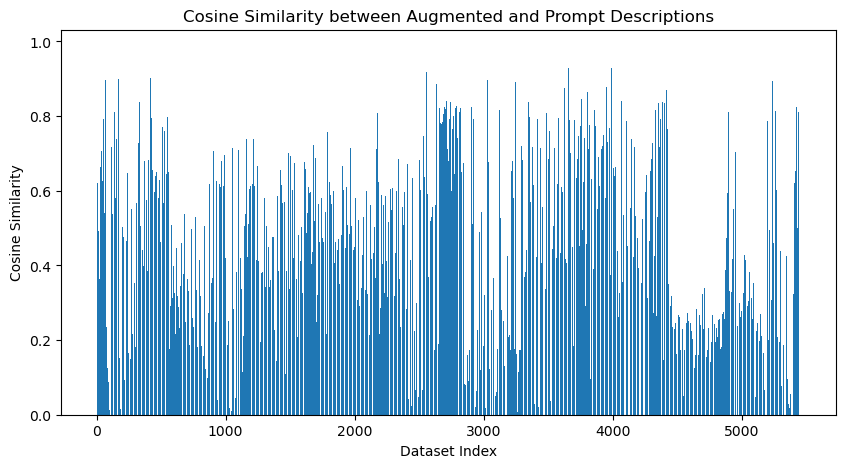

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

descriptions = {
    'augmented_description': augmented_df['augmented_description'],
    'prompt_description': augmented_df['prompt_description']
}
df = pd.DataFrame(descriptions)

vectorizer = TfidfVectorizer()

all_text = df['augmented_description'].tolist() + df['prompt_description'].tolist()

vectorizer.fit(all_text)

augmented_tfidf = vectorizer.transform(df['augmented_description'])
prompt_tfidf = vectorizer.transform(df['prompt_description'])

similarities = [cosine_similarity(augmented_tfidf[i], prompt_tfidf[i])[0][0] for i in range(len(df))]

plt.figure(figsize=(10, 5))
plt.title('Cosine Similarity between Augmented and Prompt Descriptions')

plt.bar(df.index, similarities)
plt.xlabel('Dataset Index')
plt.ylabel('Cosine Similarity')
plt.show()

In [18]:
# dataset indices where similarity is below .5 
for i, sim in enumerate(similarities):
    if sim < .5:
        print(i, sim)

0 0.39453896535261146
1 0.48244784138166674
5 0.41085065275318744
10 0.4931444694870049
12 0.4592442857093072
14 0.49328138049463416
16 0.49298480852793275
20 0.4904286725438785
22 0.36408076707957143
23 0.3755887430727868
28 0.4075714580227366
32 0.3267105269569613
36 0.4976792288666998
43 0.4747724658276082
44 0.47983806780258964
48 0.253328986744621
49 0.21035289544422048
55 0.41004556076995824
56 0.05803316249487675
58 0.40550935755789813
60 0.13462810135553654
62 0.0059475559465713475
63 0.0066482275971609895
64 0.44721113490780257
65 0.47227533567701724
66 0.026085674423906854
67 0.054427408634577006
69 0.17333596161509815
70 0.1771240059347819
71 0.0943258599205045
72 0.20911070988031888
73 0.148256114092456
74 0.22290099365090235
75 0.13321285648303915
76 0.23396262415870292
77 0.13338064624012627
79 0.154611744328199
80 0.02048751458724666
81 0.16257097521028147
83 0.016246908532853696
84 0.126448490230674
86 0.16322302222788296
87 0.015080284316982029
88 0.28374985180593865
8

In [19]:
print(augmented_df.loc[5269]['augmented_description'])

Name: Contaminant-detection-in-packaged-cocoa-hazelnut-spread-jars-using-Microwaves-Sensing-and-Machine-Learning-9.0GHz(Urbinati)

Tags: Chemistry, Life Science

Contaminant-detection-in-packaged-cocoa-hazelnut-spread-jars-using-Microwaves-Sensing-and-Machine-Learning-9.0GHz(Urbinati)
----------------

This dataset is part of a series of five different datasets
each one measured with a different microwave frequency: 9.0, 9.5, 10.0, 10.5, 11.0 GHz.
PAY ATTENTION: THE DATASET PRESENTED IN THIS PAGE HAS BEEN ACQUIRED AT 9.0 GHz!
IF YOU ARE LOOKING FOR THE OTHER FOUR DATASETS, VISIT THE OPENML PROFILE
OF THE AUTHOR OF THIS DATASET.

The following description is valid for all the five datasets.

Dataset description.
To detect contaminants accidentally included in industrial food,
Microwave Sensing (MWS) can be used as a contactless detection method,
in particular when the food is already packaged.

MWS uses microwaves to illuminate the target object through a set of antennas,
records the sc

In [20]:
print(augmented_df.loc[5269]['prompt_description'])

Contaminant Detection in Packaged Cocoa Hazelnut Spread Jars using Microwaves Sensing and Machine Learning 

This dataset is part of a series of five different datasets, each one measured with a different microwave frequency. 

Dataset Description 

To detect contaminants accidentally included in industrial food, Microwave Sensing can be used as a contactless detection method, particularly when the food is already packaged. Microwave Sensing uses microwaves to illuminate the target object through a set of antennas, records the scattered waves, and uses Machine Learning to predict the presence of contaminants inside the target object. In this application, the target object is a cocoa hazelnut spread jar, and each instance, or sample, of this dataset consists of thirty scattering parameters of the network composed by antennas, target object, with or without a contaminant inside, and medium, or the air, in between. The types of contaminants vary from metal to glass and plastic.

Each samp

# Embeddings setup

## Load embedding model

In [21]:
from sentence_transformers import SentenceTransformer

# embedding_model = SentenceTransformer("all-mpnet-base-v2")
embedding_model = SentenceTransformer("Salesforce/SFR-Embedding-Mistral")
embedding_model

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 4096, 'do_lower_case': False}) with Transformer model: MistralModel 
  (1): Pooling({'word_embedding_dimension': 4096, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': True, 'include_prompt': True})
)

## Token count distribution

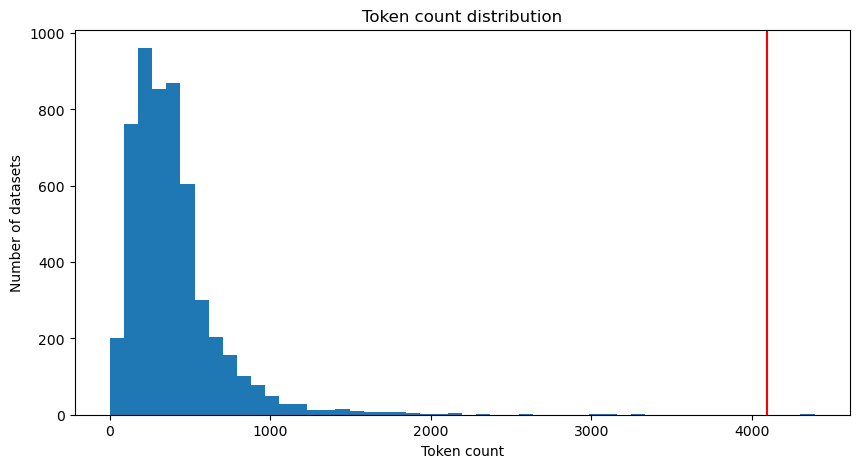

In [22]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Salesforce/SFR-Embedding-Mistral")
token_lens = []

for txt in data:
    tokens = tokenizer.encode(txt, max_length=50000, truncation=False)
    token_lens.append(len(tokens))

max_seq_len = embedding_model.max_seq_length

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.axvline(x=max_seq_len, color='red')
plt.title('Token count distribution')
plt.xlabel('Token count')
plt.ylabel('Number of datasets')

plt.hist(token_lens, bins=50)
plt.show()

In [23]:
# calculate percentage of all text that falls beyound the max_seq_len
max_seq_len = embedding_model.max_seq_length

count = 0
for tokens in token_lens:
    if tokens > max_seq_len:
        count += 1

print(f"{count / len(token_lens) * 100:.2f}%")

0.02%


In [24]:
for i, tokens in enumerate(token_lens):
    if tokens > 8000:
        print(i, tokens)

## Calculate embeddings

This step is run on demand and not every single time, as it requires a powerful GPU to run the embedding model.

In [27]:
# embeddings = embedding_model.encode(data, show_progress_bar=True, batch_size=1)
# np.save('embeddings_prompts.npy', embeddings)

In [28]:
embeddings = np.load('embeddings_prompts.npy')

# Topic models

## BERTopic simple zeroshot classification model

This model uses a simple form of zeroshot classification, where a zeroshot topic list is first predefined and loaded. Then, in the first step of the model, the cosine similarity of each description and the topic list is calculated. If the similarity is above a certain threshold, the topic is assigned to the description. If not, the description is passed to the BERTopic model for further processing.

This is a "naive" model, as only simple cosine similarity is used for classification. The model is not very accurate, but it is a good starting point for further development.

In [29]:
import json

with open('data/categories.json') as f:
    zeroshot_topic_list = json.load(f)

zeroshot_topic_list

['Agriculture',
 'Astronomy',
 'Chemistry',
 'Computational Universe',
 'Computer Systems',
 'Climate and Environment',
 'Culture',
 'Demographics',
 'Earth Science',
 'Economics',
 'Education',
 'Engineering',
 'Geography',
 'Government',
 'Games',
 'Health',
 'History',
 'Human Activities',
 'Images',
 'Language',
 'Law',
 'Life Science',
 'Machine Learning',
 'Manufacturing',
 'Mathematics',
 'Medicine',
 'Meteorology',
 'Physical Sciences',
 'Politics',
 'Social Media',
 'Sociology',
 'Statistics',
 'Text & Literature',
 'Transportation']

In [30]:
# vectorizer_model = CountVectorizer(
#     # tokenizer=spacy_lemmatizer,
#     stop_words="english",
#     ngram_range=(1, 1))
# 
# # representation_model = KeyBERTInspired()
# # representation_model = MaximalMarginalRelevance(diversity=0.3)
# ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
# umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# 
# topic_model_1 = BERTopic(
#     verbose=True,
#     # nr_topics=50,
#     ctfidf_model=ctfidf_model,
#     calculate_probabilities=True,
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     embedding_model=embedding_model,
#     vectorizer_model=vectorizer_model,
#     # representation_model=representation_model,
#     zeroshot_topic_list=zeroshot_topic_list,
#     zeroshot_min_similarity=.43,
# )
# topics, probs = topic_model_1.fit_transform(data, embeddings)

In [31]:
# umap_model.fit_transform(embeddings)

In [32]:
# hdbscan_model.fit(umap_model.transform(embeddings)).labels_

In [33]:
# sequence_to_classify = " ".join([word for word, _ in topic_model_1.get_topic(1)])
# sequence_to_classify

In [34]:
# topic_model_1.transform(data[0], embeddings[0])

In [35]:
# topic_model_1.get_topic_info()

In [36]:
# topic_model_1.visualize_barchart(top_n_topics=len(topic_model_1.get_topic_info()), custom_labels=True)
# topic_model_1.visualize_barchart()

In [37]:
# topic_model_1.get_topic(0, True)

In [38]:
# reduced_embeddings = UMAP(n_neighbors=10, n_components=2,
#                           min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [39]:
# topic_model_1.visualize_documents(data, reduced_embeddings=reduced_embeddings, hide_annotations=True)

In [40]:
# topic_model_1.visualize_topics()

In [41]:
# similar_topics, similarity = topic_model_1.find_topics("trading", top_n=5)
# topic_model_1.get_topic(similar_topics[0])

## BERTopic maximal marginal relevance model (unsupervised)

This model is an unsupervised model, where a maximal marginal relevance representation model is used to remove similar terms. It is unsupervised, because it uncovers latent topics.

In [42]:
# from bertopic.representation import MaximalMarginalRelevance
# 
# vectorizer_model = CountVectorizer(
#     tokenizer=spacy_lemmatizer,
#     stop_words="english",
#     ngram_range=(1, 2))
# 
# representation_model = MaximalMarginalRelevance(diversity=0.3)
# ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
# umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# 
# topic_model_2 = BERTopic(
#     verbose=True,
#     # nr_topics=50,
#     ctfidf_model=ctfidf_model,
#     calculate_probabilities=True,
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     embedding_model=embedding_model,
#     # vectorizer_model=vectorizer_model,
#     representation_model=representation_model,
# )
# # topics, probs = topic_model_2.fit_transform(data, embeddings)

In [43]:
# topic_model_2.get_topic_info()

In [44]:
# topic_model_2.get_document_info(data)

In [45]:
# topic_model_2.visualize_barchart(top_n_topics=30)

## BERTopic zeroshot classification model

This model is different from the simple zeroshot classification model, as it uses a zeroshot classifier as the representation model. That means BERTopic runs all previous steps, i.e. c-TF-IDF, UMAP, HDBScan, and then passes the top representative documents to the zeroshot classifier. The zeroshot classifier then classifies the documents into the predefined topics.

In [53]:
from src.bertopic_extensions import zero_shot_classification
importlib.reload(zero_shot_classification)

from src.bertopic_extensions import ZeroShotClassification
import json

with open('data/categories.json') as f:
    zeroshot_topic_list = json.load(f)

vectorizer_model = CountVectorizer(
    tokenizer=spacy_lemmatizer,
    stop_words="english",
    ngram_range=(1, 2))

hypothesis_template = "This text is about {}"

representation_model = ZeroShotClassification(zeroshot_topic_list, model="MoritzLaurer/bge-m3-zeroshot-v2.0", min_prob=0.5, pipeline_kwargs={
    "multi_label": True,
    "hypothesis_template": hypothesis_template
})

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

topic_model_3 = BERTopic(
    verbose=True,
    # nr_topics=50,
    ctfidf_model=ctfidf_model,
    calculate_probabilities=True,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    # vectorizer_model=vectorizer_model,
    representation_model=representation_model,
)
topics, probs = topic_model_3.fit_transform(data, embeddings)

2024-05-09 03:46:30,754 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-09 03:46:37,039 - BERTopic - Dimensionality - Completed ✓
2024-05-09 03:46:37,040 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-09 03:46:46,107 - BERTopic - Cluster - Completed ✓
2024-05-09 03:46:46,110 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 272/272 [5:29:49<00:00, 72.76s/it]  
2024-05-09 09:16:37,435 - BERTopic - Representation - Completed ✓


The problem with this default approach is that only the candidate topics as calculated with c-TF-IDF are passed to the representation model. This will make the model run faster, but will not take all the context into account.

A better alternative would be to write our own zero shot classification implementation for BERTopic, where we pass also the top **k** representative docs (up to 8192 tokens in total for the bge-m3-zeroshot model).

Another alternative is text generation, instead of classification. 

In [ ]:
# Example
text = "Angela Merkel is a politician in Germany and leader of the CDU"
hypothesis_template = "This text is about {}"
classes_verbalized = zeroshot_topic_list 
zeroshot_classifier = representation_model.model 

In [ ]:
output = zeroshot_classifier(data[4500], classes_verbalized, hypothesis_template=hypothesis_template, multi_label=True)
print(output)

In [54]:
topic_model_3.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,901,-1_Chemistry___,"[Chemistry, , , , , , , , , ]","[This dataset, named QSAR-TID-103446, belongs ..."
1,0,208,0_Chemistry_Mathematics_Life Science_,"[Chemistry, Mathematics, Life Science, , , , ,...",[Fri C Four Two Fifty Twenty Five Dataset \n\n...
2,1,83,1_Computer Systems___,"[Computer Systems, , , , , , , , , ]",[Timing Attack Dataset Fifteen Micro Seconds D...
3,2,64,2_Health_Medicine__,"[Health, Medicine, , , , , , , , ]",[Heart Long Beach Dataset\n\nThis dataset cont...
4,3,52,3_Mathematics_Computer Systems__,"[Mathematics, Computer Systems, , , , , , , , ]",[The Friedman datasets are eighty artificially...
...,...,...,...,...,...
267,266,5,266_Health_Life Science__,"[Health, Life Science, , , , , , , , ]",[This collection includes datasets of one dime...
268,267,5,267_Health_Medicine__,"[Health, Medicine, , , , , , , , ]",[Thoracic Surgery Data Set\n\nThe data set is ...
269,268,5,268_dkk_minute_nok_recorded,"[dkk, minute, nok, recorded, eur, changed, beg...",[**FOREX Euro/Swedish Krona Minute Close**\n\n...
270,269,5,269_Mathematics_Agriculture__,"[Mathematics, Agriculture, , , , , , , , ]","[Name: Albert \n\nTags: Economics, Life Scienc..."


In [55]:
topic_model_3.get_document_info(data)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,"Anneal \nTags: Manufacturing, Study One, Study...",164,164_steel_annealing_valued_temper,"[steel, annealing, valued, temper, luminosity,...",[**Anneal**\n**Tags:** \n\nTitle of Database: ...,steel - annealing - valued - temper - luminosi...,1.000000,True
1,**Chess End-Game - King + Rook versus King + P...,114,114_Games___,"[Games, , , , , , , , , ]",[This dataset is part of a collection of datas...,Games - - - - - - - - -,0.008810,False
2,**Labor Negotiations**\n\nThis dataset pertain...,26,26_casebook_intruder_canada_stern,"[casebook, intruder, canada, stern, gopher, bo...","[Background:\n\nIn this paper, we develop an a...",casebook - intruder - canada - stern - gopher ...,0.004413,False
3,"Arrhythmia \n\nTags: Machine Learning, Medicin...",2,2_Health_Medicine__,"[Health, Medicine, , , , , , , , ]",[Heart Long Beach Dataset\n\nThis dataset cont...,Health - Medicine - - - - - - - -,0.486508,False
4,Title: Letter Image Recognition Data\n\nThe ob...,-1,-1_Chemistry___,"[Chemistry, , , , , , , , , ]","[This dataset, named QSAR-TID-103446, belongs ...",Chemistry - - - - - - - - -,0.868504,False
...,...,...,...,...,...,...,...,...
5278,,118,118_ratios_cash_credit_parties,"[ratios, cash, credit, parties, checking, liqu...",[Dataset Thirty-One Credit-G \n\nTags: Chemist...,ratios - cash - credit - parties - checking - ...,1.000000,False
5279,,21,21_Economics___,"[Economics, , , , , , , , , ]",[Padding Attack Dataset OpenSSL 0.9.7a \n\nTag...,Economics - - - - - - - - -,0.137074,False
5280,,116,116_Computer Systems___,"[Computer Systems, , , , , , , , , ]","[KDDCup99 full Dataset \n\nTags: Chemistry, Co...",Computer Systems - - - - - - - - -,0.302566,False
5281,,116,116_Computer Systems___,"[Computer Systems, , , , , , , , , ]","[KDDCup99 full Dataset \n\nTags: Chemistry, Co...",Computer Systems - - - - - - - - -,0.209419,False


In [63]:
# get max seq length of the model
representation_model.model.model

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(8194, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_f

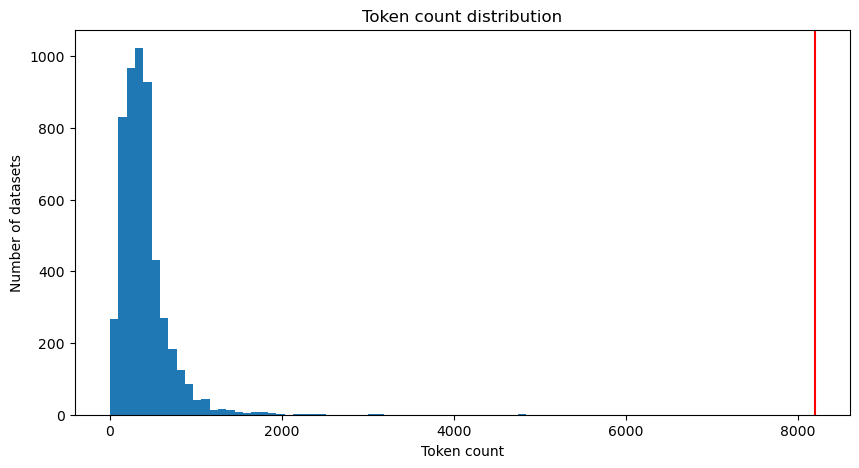

In [64]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("MoritzLaurer/bge-m3-zeroshot-v2.0")
token_lens = []

for txt in data:
    tokens = tokenizer.encode(txt, max_length=50000, truncation=False)
    token_lens.append(len(tokens))

max_seq_len = 8194 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.axvline(x=max_seq_len, color='red')
plt.title('Token count distribution')
plt.xlabel('Token count')
plt.ylabel('Number of datasets')

plt.hist(token_lens, bins=50)
plt.show()